In [5]:
import csv 
import re 
import pickle
import random

import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn

import utils
from models.vae import VariationalAutoencoder, LSTMVariationalAutoencoder

from pyjarowinkler import distance
import sqlite3

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [6]:
%reload_ext autoreload
%autoreload 2

# Table of Contents

### Data import and creating matches / nonmatches datasets 
 - IOWA 
 - Military 
 
#### Jaro-Winkler

# Data

### Iowa 
Names from Iowa census linked between 1915 and 1940. 

In [7]:
names = pd.read_csv('data/iowamatched19151940.csv')
# Clean up punctuation and lower case 
names['lname.1915'] = names['lname.1915'].apply(lambda x: (re.sub(r'[^a-z|\s]', '', x.lower()).strip()).strip())
names['fname.1915'] = names['fname.1915'].apply(lambda x: (re.sub(r'[^a-z|\s]', '', x.lower()).strip()).strip())
names['lname.1940'] = names['lname.1940'].apply(lambda x: (re.sub(r'[^a-z|\s]', '', x.lower()).strip()).strip())
names['fname.1940'] = names['fname.1940'].apply(lambda x: (re.sub(r'[^a-z|\s]', '', x.lower()).strip()).strip())

handlinks = pd.read_csv('data/iowa_sons_linked_1915_1940_with_regions.csv')
names = names[['uid.1915', 'lname.1915', 'fname.1915', 'yob.1915', 
               'hhid', 'hhorder', 'fname.1940', 'lname.1940', 'yob.1940']]

# Add uid-hhid column to filter out matches below
names['uid-hhid'] = names['uid.1915'] + '-' + names['hhid'].apply(lambda x: str(x))

names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79343 entries, 0 to 79342
Data columns (total 10 columns):
uid.1915      79343 non-null object
lname.1915    79343 non-null object
fname.1915    79343 non-null object
yob.1915      79343 non-null int64
hhid          79343 non-null int64
hhorder       79343 non-null int64
fname.1940    79343 non-null object
lname.1940    79343 non-null object
yob.1940      79343 non-null int64
uid-hhid      79343 non-null object
dtypes: int64(4), object(6)
memory usage: 6.1+ MB


In [8]:
names.head()

,uid.1915,lname.1915,fname.1915,yob.1915,hhid,hhorder,fname.1940,lname.1940,yob.1940,uid-hhid
0,uid0035087222,chalder,raymond,1898,13226,1,raymond,mcaleer,1901,uid0035087222-13226
1,uid0016097261,nelson,george,1898,35678,1,george allen,egelston,1896,uid0016097261-35678
2,uid0035087223,chalder,frank,1899,36077,1,frank ray,claver,1901,uid0035087223-36077
3,uid0016006015,nelson,paul f,1900,5471,9,paul m,welson,1902,uid0016006015-5471
4,uid0314012044,fleck,george d,1900,11292,1,george d,loreck,1899,uid0314012044-11292


Create dataframes for matches and nonmatches 

In [9]:
conn = sqlite3.connect(':memory:')
names.to_sql('names', conn)
handlinks.to_sql('handlinks', conn)  # Dataframe of ground truth matches

# Match is based on UID for 1915 names and HHID in handlinks

matches_query = '''
    SELECT 
        names.`uid.1915` as uid1915, 
        names.`fname.1915` as fname1915,
        names.`lname.1915` as lname1915,
        names.`fname.1915` || ' ' || names.`lname.1915` as fullname1915, 
        names.`yob.1915` as yob1915, 
        names.`hhid` as hhid, 
        names.`fname.1940` as fname1940, 
        names.`lname.1940` as lname1940, 
        names.`fname.1940` || ' ' || names.`lname.1940` as fullname1940, 
        names.`yob.1940` as yob1940 
    FROM handlinks
    LEFT JOIN names as names on names.`uid.1915` = handlinks.uid AND names.`hhid` = handlinks.hhid
    WHERE uid1915 is not null
'''

matches = pd.read_sql_query(matches_query, conn)
matches['uid-hhid'] = matches['uid1915'] + '-' + matches['hhid'].apply(lambda x: str(x))
matches.info()
matches.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 11 columns):
uid1915         4320 non-null object
fname1915       4320 non-null object
lname1915       4320 non-null object
fullname1915    4320 non-null object
yob1915         4320 non-null int64
hhid            4320 non-null int64
fname1940       4320 non-null object
lname1940       4320 non-null object
fullname1940    4320 non-null object
yob1940         4320 non-null int64
uid-hhid        4320 non-null object
dtypes: int64(3), object(8)
memory usage: 371.3+ KB


,uid1915,fname1915,lname1915,fullname1915,yob1915,hhid,fname1940,lname1940,fullname1940,yob1940,uid-hhid
0,uid0910071227,donald d,cutler,donald d cutler,1911,19067,donald dean,cutler,donald dean cutler,1911,uid0910071227-19067
1,uid0063131339,homer,taylor,homer taylor,1912,71505,homer ellis,taylor,homer ellis taylor,1912,uid0063131339-71505
2,uid0044088276,earl,stearnes,earl stearnes,1899,109708,earl,stearns,earl stearns,1900,uid0044088276-109708
3,uid0067053130,theodore,hornaday,theodore hornaday,1904,108304,theodore i,harnaday,theodore i harnaday,1904,uid0067053130-108304
4,uid0066046148,jack r,turner,jack r turner,1907,105092,jack r,turner,jack r turner,1907,uid0066046148-105092


In [10]:
# Nonmatches are found by filter out uid-hhid rows which occur in the matches dataset 
nonmatches = names[~names['uid-hhid'].isin(matches['uid-hhid'])]

# Create columns for full name 
nonmatches['fullname1915'] = nonmatches['fname.1915'] + ' ' + nonmatches['lname.1915']
nonmatches['fullname1940'] = nonmatches['fname.1940'] + ' ' + nonmatches['lname.1940']

# Rename columns 
nonmatches.columns = ['uid1915', 'lname1915', 'fname1915', 'yob1915', 'hhid', 'hhorder', 
                      'fname1940', 'lname1940', 'yob1940', 'uid-hhid', 'fullname1915', 'fullname1940']
nonmatches.info()
nonmatches.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75023 entries, 0 to 79342
Data columns (total 12 columns):
uid1915         75023 non-null object
lname1915       75023 non-null object
fname1915       75023 non-null object
yob1915         75023 non-null int64
hhid            75023 non-null int64
hhorder         75023 non-null int64
fname1940       75023 non-null object
lname1940       75023 non-null object
yob1940         75023 non-null int64
uid-hhid        75023 non-null object
fullname1915    75023 non-null object
fullname1940    75023 non-null object
dtypes: int64(4), object(8)
memory usage: 7.4+ MB


,uid1915,lname1915,fname1915,yob1915,hhid,hhorder,fname1940,lname1940,yob1940,uid-hhid,fullname1915,fullname1940
0,uid0035087222,chalder,raymond,1898,13226,1,raymond,mcaleer,1901,uid0035087222-13226,raymond chalder,raymond mcaleer
1,uid0016097261,nelson,george,1898,35678,1,george allen,egelston,1896,uid0016097261-35678,george nelson,george allen egelston
2,uid0035087223,chalder,frank,1899,36077,1,frank ray,claver,1901,uid0035087223-36077,frank chalder,frank ray claver
3,uid0016006015,nelson,paul f,1900,5471,9,paul m,welson,1902,uid0016006015-5471,paul f nelson,paul m welson
4,uid0314012044,fleck,george d,1900,11292,1,george d,loreck,1899,uid0314012044-11292,george d fleck,george d loreck


# Distance Baseline: Jaro-Winkler

In [11]:
matches['full-jaro-winkler'] = matches.apply(lambda row: distance.get_jaro_distance(row.fullname1915, row.fullname1940), axis=1)
nonmatches['full-jaro-winkler'] = nonmatches.apply(lambda row: distance.get_jaro_distance(row.fullname1915, row.fullname1940), axis=1)

matches['first-jaro-winkler'] = matches.apply(lambda row: distance.get_jaro_distance(row.fname1915, row.fname1940), axis=1)
nonmatches['first-jaro-winkler'] = nonmatches.apply(lambda row: distance.get_jaro_distance(row.fname1915, row.fname1940), axis=1)

matches['last-jaro-winkler'] = matches.apply(lambda row: distance.get_jaro_distance(row.lname1915, row.lname1940), axis=1)
nonmatches['last-jaro-winkler'] = nonmatches.apply(lambda row: distance.get_jaro_distance(row.lname1915, row.lname1940), axis=1)

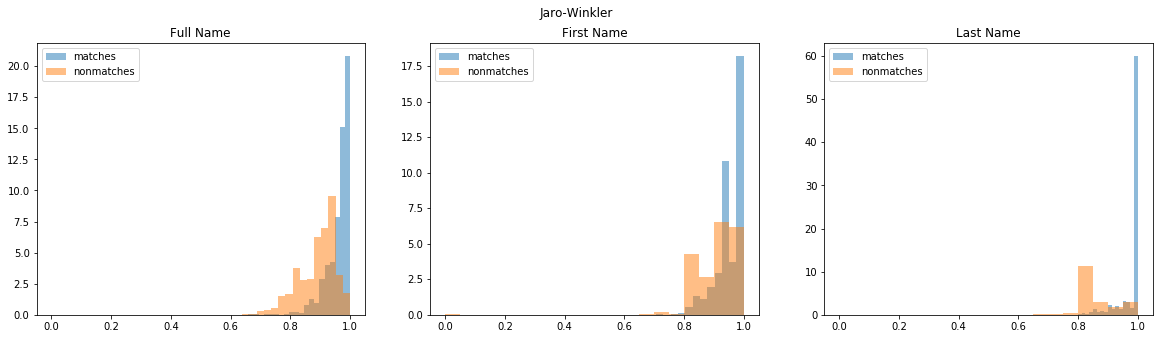

In [12]:
f, axes = plt.subplots(1,3, sharex=True, figsize=(20,5))
f.suptitle('Jaro-Winkler')
axes[0].hist(matches['full-jaro-winkler'], alpha=.5, bins=20, label='matches', normed=True)
axes[0].hist(nonmatches['full-jaro-winkler'], alpha=.5, bins=20, label='nonmatches', normed=True)
axes[0].legend(loc='upper left')
axes[0].set_title('Full Name')

axes[1].hist(matches['first-jaro-winkler'], alpha=.5, bins=20, label='matches', normed=True)
axes[1].hist(nonmatches['first-jaro-winkler'], alpha=.5, bins=20, label='nonmatches', normed=True)
axes[1].legend(loc='upper left')
axes[1].set_title('First Name')

axes[2].hist(matches['last-jaro-winkler'], alpha=.5, bins=20, label='matches', normed=True)
axes[2].hist(nonmatches['last-jaro-winkler'], alpha=.5, bins=20, label='nonmatches', normed=True)
axes[2].legend(loc='upper left')
axes[2].set_title('Last Name')

# Feed Forward Variational Autoencoder 

In [16]:
# Matches - Try last names only 
max_length = 25
pairs = utils.k_shingles(2)

match_lnamesA = [utils.embed_shingles(name, max_length) for name in matches['lname1915']]
match_lnamesA = [item[0] for item in match_lnamesA]
match_lnamesA = np.vstack(match_lnamesA)

match_lnamesB = [utils.embed_shingles(name, max_length) for name in matches['lname1940']]
match_lnamesB = [item[0] for item in match_lnamesB]
match_lnamesB = np.vstack(match_lnamesB)

# Nonmatches 
nonmatch_lnamesA = [utils.embed_shingles(name, max_length) for name in nonmatches['lname1915']]
nonmatch_lnamesA = [item[0] for item in nonmatch_lnamesA]
nonmatch_lnamesA = np.vstack(nonmatch_lnamesA)

nonmatch_lnamesB = [utils.embed_shingles(name, max_length) for name in nonmatches['lname1940']]
nonmatch_lnamesB = [item[0] for item in nonmatch_lnamesB]
nonmatch_lnamesB = np.vstack(nonmatch_lnamesB)

In [23]:
vae5 = VariationalAutoencoder(encode_units=[128,128],
                              latent_units=16,
                              seed=5555, 
                              batch_size=32, 
                              learning_rate=1e-4) 

training_mu5, median_mu5 = vae5.train(nonmatch_lnamesA, test=0.1, epochs=300, 
                                      model=None)

Created 2110 batches of size 32
Input: (?, 25)
FC (?, 128)
FC (?, 128)
Mu (?, 16) Log Sigma (?, 16)
Z (?, 16)
Decode FC (?, 128)
Decode FC (?, 128)
Decoded: (?, 25)
Epoch 0 Avg Train Loss: 12.580932 Val Loss 293.788483
Epoch 10 Avg Train Loss: 1.212051 Val Loss 67.893501
Epoch 20 Avg Train Loss: 1.055792 Val Loss 54.679153
Epoch 30 Avg Train Loss: 1.020278 Val Loss 53.152981
Epoch 40 Avg Train Loss: 1.001942 Val Loss 49.080830
Epoch 50 Avg Train Loss: 0.990363 Val Loss 48.851971
Epoch 60 Avg Train Loss: 0.978463 Val Loss 48.529026
Epoch 70 Avg Train Loss: 0.969826 Val Loss 46.454548
Epoch 80 Avg Train Loss: 0.959341 Val Loss 45.322029
Epoch 90 Avg Train Loss: 0.953018 Val Loss 46.901123
Epoch 100 Avg Train Loss: 0.947934 Val Loss 45.145077
Epoch 110 Avg Train Loss: 0.945203 Val Loss 44.441345
Epoch 120 Avg Train Loss: 0.940875 Val Loss 42.130989
Epoch 130 Avg Train Loss: 0.935650 Val Loss 43.905449
Epoch 140 Avg Train Loss: 0.930602 Val Loss 43.457088
Epoch 150 Avg Train Loss: 0.928101

In [24]:
median_mu_path = 'vae_model/latent-units16-val-loss43.192047-lr0.0001'+'_median_mu.p'
with open(median_mu_path, 'wb') as p: 
    pickle.dump(median_mu5, p) 
print('Saved Median Mu:', median_mu5) 

Saved Median Mu: [-3.0143790e-02 -3.5277382e-04 -6.9904171e-02  1.3184659e-03
 -7.4498355e-05  8.3863676e-02  5.4223910e-03  1.1274762e-01
 -3.0093938e-03  1.7633064e-02 -2.8772071e-01  1.9817963e-02
  6.1034188e-03 -8.0121867e-03  2.1454291e-03  2.8089147e-02]


In [25]:
with open(median_mu_path, 'rb') as p: 
    median_mu = pickle.load(p)

In [26]:
print(median_mu)

[-3.0143790e-02 -3.5277382e-04 -6.9904171e-02  1.3184659e-03
 -7.4498355e-05  8.3863676e-02  5.4223910e-03  1.1274762e-01
 -3.0093938e-03  1.7633064e-02 -2.8772071e-01  1.9817963e-02
  6.1034188e-03 -8.0121867e-03  2.1454291e-03  2.8089147e-02]


INFO:tensorflow:Restoring parameters from vae_model/latent-units16-val-loss43.192047-lr0.0001
INFO:tensorflow:Restoring parameters from vae_model/latent-units16-val-loss43.192047-lr0.0001
INFO:tensorflow:Restoring parameters from vae_model/latent-units16-val-loss43.192047-lr0.0001
INFO:tensorflow:Restoring parameters from vae_model/latent-units16-val-loss43.192047-lr0.0001


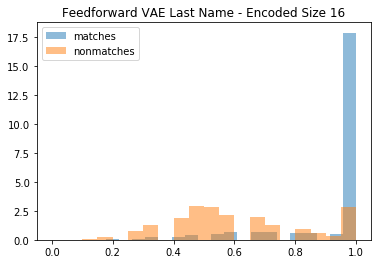

In [29]:
def get_binary_hash(names, model_path='vae_model/latent-units16-val-loss43.192047-lr0.0001'):
    if model_path is None:
        model_path = self.model_path
        median_mu = self.median_mu 
    else: 
        with open(model_path + '_median_mu.p', 'rb') as p: 
            median_mu = pickle.load(p)

    tf.reset_default_graph()
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(model_path + '.meta')
        saver.restore(sess, model_path)
        input_x = sess.graph.get_tensor_by_name('inputs/input_x:0')
        z_size = sess.graph.get_tensor_by_name('inputs/z_size:0')
        encode_mu = sess.graph.get_tensor_by_name('encode/mu/BiasAdd:0')

        # Normalize by training max
        names_normalized = names / 729
        # Encode
        new_mu = sess.run(encode_mu, feed_dict={input_x: names_normalized,
                                                z_size: len(names_normalized)})
        # Compare to median
        binary = []
        for row in range(new_mu.shape[0]):
            binary.append(np.array([1 if e >= median_mu[i] else 0 for i,e in enumerate(new_mu[row])]))
    return np.vstack(binary)
    
lastname_nonmatchA_binary =  get_binary_hash(nonmatch_lnamesA)
lastname_nonmatchB_binary = get_binary_hash(nonmatch_lnamesB)

lastname_matchA_binary = get_binary_hash(match_lnamesA)
lastname_matchB_binary = get_binary_hash(match_lnamesB)

# L1
nonmatch_distance5 = [] 
nonmatch_diff5 = lastname_nonmatchA_binary - lastname_nonmatchB_binary
for row in range(nonmatch_diff5.shape[0]):
    nonmatch_distance5.append(sum(abs(nonmatch_diff5[row,:])))

match_distance5 = [] 
match_diff5 = lastname_matchA_binary - lastname_matchB_binary
for row in range(match_diff5.shape[0]):
    match_distance5.append(sum(abs(match_diff5[row,:])))

# Normalize distances 
max_distance = max(max(match_distance5), max(nonmatch_distance5))
min_distance = 0 
nonmatch_distance5 = [1-((x-min_distance)/(max_distance-min_distance)) 
                      for x in nonmatch_distance5]
match_distance5 = [1-((x-min_distance)/(max_distance-min_distance)) 
                   for x in match_distance5]

matches['vae_enc_last'] = match_distance5
nonmatches['vae_enc_last'] = nonmatch_distance5

plt.hist(matches['vae_enc_last'], alpha=.5, bins=20, label='matches', normed=1)
plt.hist(nonmatches['vae_enc_last'], alpha=.5, bins=20, label='nonmatches',normed=1)
plt.legend(loc='upper left')
plt.title('Feedforward VAE Last Name - Encoded Size 16')

In [72]:
list_nonmatch_binary = [i.reshape(-1) for i in np.vsplit(lastname_nonmatchA_binary, len(lastname_nonmatchA_binary))]
list_nonmatch_binary

[array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]),
 array([0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]),
 array([1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]),
 array([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]),
 array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1]),
 array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]),
 array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1]),
 array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1]),
 array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]),
 array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]),
 array([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]),
 array([0, 1, 

0.2747372780989139


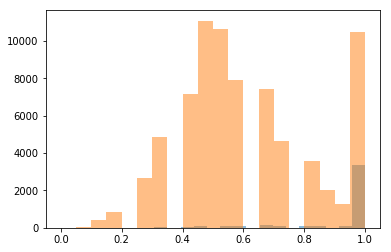

In [31]:
n,b,p = plt.hist(matches['vae_enc_last'], alpha=.5, bins=20, label='matches')
nn,nb,npatches = plt.hist(nonmatches['vae_enc_last'], alpha=.5, bins=20, label='nonmatches')

n = n/len(matches)
nn = nn/len(nonmatches)

vae_enc5_overlap = 0 
for i, e in enumerate(n): 
    vae_enc5_overlap += min(e, nn[i])  
print(vae_enc5_overlap)

# Difference in Trained Embeddings

Train Embeddings 

In [991]:
# Get int corpus of shingles using the nonmatches 1915 last names 
last_shingle_corpus = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['lname1915']]
last_shingle_corpus = [item[0][:item[1]] for item in last_shingle_corpus]

# Shingle embedding 
last_shingle_model = Word2Vec(last_shingle_corpus, min_count=1, window=2, sg=0, size=150, workers=4)
last_shingle_model.train(last_shingle_corpus, total_examples=len(last_shingle_corpus), epochs=50)

(6726314, 12579400)

In [992]:
last_shingle_model.wv.most_similar('es')

[('ay', 0.38253307342529297),
 ('u ', 0.36747321486473083),
 ('by', 0.33017006516456604),
 ('x ', 0.28935641050338745),
 ('us', 0.21610160171985626),
 ('xe', 0.21355603635311127),
 ('gu', 0.20686623454093933),
 ('az', 0.20471595227718353),
 ('ms', 0.20361275970935822),
 ('db', 0.2017061412334442)]

In [993]:
last_shingle_model.wv.most_similar('ou')

[('au', 0.41877874732017517),
 ('cx', 0.37327998876571655),
 ('oi', 0.3518819510936737),
 ('ai', 0.33991268277168274),
 ('ar', 0.33646976947784424),
 ('ri', 0.3202507197856903),
 ('cy', 0.298382043838501),
 ('uy', 0.295475035905838),
 ('os', 0.2810325026512146),
 ('', 0.2805573046207428)]

In [847]:
# Get int corpus of shingles using the nonmatches 1915 first names 
first_shingle_corpus = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['fname1915']]
first_shingle_corpus = [item[0][:item[1]] for item in first_shingle_corpus]

# Shingle embedding 
first_shingle_model = Word2Vec(first_shingle_corpus, min_count=1, window=2, sg=0, size=150, workers=4)
first_shingle_model.train(first_shingle_corpus, total_examples=len(first_shingle_corpus), epochs=50)

(5525663, 12524700)

In [976]:
first_shingle_model.wv.most_similar('es')

[('pe', 0.529647171497345),
 ('dd', 0.5043237209320068),
 ('et', 0.4846804738044739),
 ('tu', 0.4069869816303253),
 ('fe', 0.35389450192451477),
 ('ut', 0.3150250315666199),
 ('ba', 0.3028024435043335),
 ('iu', 0.27876603603363037),
 ('bi', 0.2751031816005707),
 ('it', 0.2625027596950531)]

In [867]:
# Letter embedding using last names 
last_letter_corpus = [list(name) for name in nonmatches['lname1915']]

last_letter_model = Word2Vec(last_letter_corpus, min_count=1, window=3, sg=1, size=50, workers=4)
last_letter_model.train(last_letter_corpus, total_examples=len(last_letter_corpus), epochs=20)

last_letter_model.wv.most_similar('a')

[('e', 0.6126770377159119),
 ('i', 0.5618269443511963),
 ('u', 0.4862372875213623),
 ('o', 0.4479182958602905),
 ('s', 0.31614622473716736),
 ('g', 0.30135399103164673),
 ('l', 0.29962414503097534),
 (' ', 0.2643076181411743),
 ('r', 0.26340925693511963),
 ('n', 0.2595965564250946)]

In [866]:
# Letter embedding using first names 
first_letter_corpus = [list(name) for name in nonmatches['fname1915']]

first_letter_model = Word2Vec(first_letter_corpus, min_count=1, window=2, sg=0, size=50, workers=4)
first_letter_model.train(first_letter_corpus, total_examples=len(first_letter_corpus), epochs=20)

first_letter_model.wv.most_similar('a')

[('i', 0.20447096228599548),
 ('e', 0.1416505128145218),
 ('v', 0.09893343597650528),
 ('o', 0.08183715492486954),
 ('w', 0.07614424079656601),
 ('y', 0.052115343511104584),
 ('t', 0.050977885723114014),
 ('b', 0.045989636331796646),
 ('x', 0.04292662441730499),
 ('f', 0.0025932565331459045)]

In [933]:
def avg_similarity(A, B, model):
    max_length = max(len(A), len(B))
    min_length = min(len(A), len(B))
    similarities = [] 
    for i in range(min_length):
        try:
            similarities.append(model.wv.similarity(A[i], B[i]))
        except KeyError:
            similarities.append(0.0)
    similarities.extend([0.5]*(max_length-min_length))
    return min(max(0, np.mean(similarities)),1.0)

In [1106]:
# Pad nameA and nameB to max(len(A), len(B))
# Embed each shingle 
# Take average similarity

# Shingles - last names 
nonmatch_corpusA = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['lname1915']]
nonmatch_corpusA = [item[0][:item[1]] for item in nonmatch_corpusA]
nonmatch_corpusB = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['lname1940']]
nonmatch_corpusB = [item[0][:item[1]] for item in nonmatch_corpusB]
nonmatch_similarities = [] 
for i,name in enumerate(nonmatch_corpusA):
      nonmatch_similarities.append(avg_similarity(name, nonmatch_corpusB[i], last_shingle_model))
nonmatches['shingle_similarity_last'] = nonmatch_similarities


match_corpusA = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in matches['lname1915']]
match_corpusA = [item[0][:item[1]] for item in match_corpusA]
match_corpusB = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in matches['lname1940']]
match_corpusB = [item[0][:item[1]] for item in match_corpusB]

match_similarities = [] 
for i,name in enumerate(match_corpusA):
      match_similarities.append(avg_similarity(name, match_corpusB[i], last_shingle_model))
matches['shingle_similarity_last'] = match_similarities


# First names 
nonmatch_corpusA = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['fname1915']]
nonmatch_corpusA = [item[0][:item[1]] for item in nonmatch_corpusA]
nonmatch_corpusB = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in nonmatches['fname1940']]
nonmatch_corpusB = [item[0][:item[1]] for item in nonmatch_corpusB]
nonmatch_similarities = [] 
for i,name in enumerate(nonmatch_corpusA):
      nonmatch_similarities.append(avg_similarity(name, nonmatch_corpusB[i], first_shingle_model))
nonmatches['shingle_similarity_first'] = nonmatch_similarities

# Shingles - first name 
match_corpusA = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in matches['fname1915']]
match_corpusA = [item[0][:item[1]] for item in match_corpusA]
match_corpusB = [utils.embed_consecutive_shingles(name, max_length=10) 
                 for name in matches['fname1940']]
match_corpusB = [item[0][:item[1]] for item in match_corpusB]

match_similarities = [] 
for i,name in enumerate(match_corpusA):
      match_similarities.append(avg_similarity(name, match_corpusB[i], first_shingle_model))
matches['shingle_similarity_first'] = match_similarities

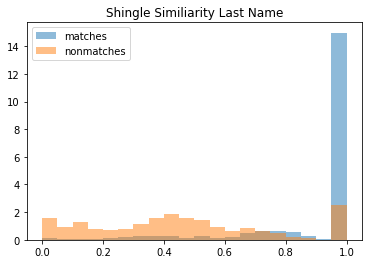

In [940]:
plt.hist(matches['shingle_similarity_last'], alpha=.5, bins=20, label='matches', normed=1)
plt.hist(nonmatches['shingle_similarity_last'], alpha=.5, bins=20, label='nonmatches',normed=1)
plt.legend(loc='upper left')
plt.title('Shingle Similiarity Last Name')

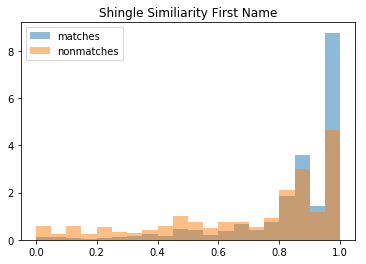

In [944]:
plt.hist(matches['shingle_similarity_first'], alpha=.5, bins=20, label='matches', normed=1)
plt.hist(nonmatches['shingle_similarity_first'], alpha=.5, bins=20, label='nonmatches',normed=1)
plt.legend(loc='upper left')
plt.title('Shingle Similiarity First Name')

In [1105]:
# Letter embedding

# Last names 
nonmatch_corpusA = [list(name) for name in nonmatches['lname1915']]
nonmatch_corpusB = [list(name) for name in nonmatches['lname1940']]

nonmatch_letter_similarities = [] 
for i,name in enumerate(nonmatch_corpusA):
      nonmatch_letter_similarities.append(avg_similarity(name, nonmatch_corpusB[i], last_letter_model))
nonmatches['letter_similarity_last'] = nonmatch_letter_similarities

match_corpusA = [list(name) for name in matches['lname1915']]
match_corpusB = [list(name) for name in matches['lname1940']]

match_letter_similarities = [] 
for i,name in enumerate(match_corpusA):
      match_letter_similarities.append(avg_similarity(name, match_corpusB[i], last_letter_model))
matches['letter_similarity_last'] = match_letter_similarities

# Letter embedding - first name 
nonmatch_corpusA = [list(name) for name in nonmatches['fname1915']]
nonmatch_corpusB = [list(name) for name in nonmatches['fname1940']]

nonmatch_letter_similarities = [] 
for i,name in enumerate(nonmatch_corpusA):
      nonmatch_letter_similarities.append(avg_similarity(name, nonmatch_corpusB[i], first_letter_model))
nonmatches['letter_similarity_first'] = nonmatch_letter_similarities

match_corpusA = [list(name) for name in matches['fname1915']]
match_corpusB = [list(name) for name in matches['fname1940']]

match_letter_similarities = [] 
for i,name in enumerate(match_corpusA):
      match_letter_similarities.append(avg_similarity(name, match_corpusB[i], first_letter_model))
matches['letter_similarity_first'] = match_letter_similarities

# ROC using Full Name

In [1109]:
# Combine matches and nonmatches into one dataframe 
matches['match'] = 1 
nonmatches['match'] = 0 

links = pd.concat([matches, nonmatches])
links.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79343 entries, 0 to 79342
Data columns (total 21 columns):
first-jaro-winkler          79343 non-null float64
fname1915                   79343 non-null object
fname1940                   79343 non-null object
full-jaro-winkler           79343 non-null float64
fullname1915                79343 non-null object
fullname1940                79343 non-null object
hhid                        79343 non-null int64
hhorder                     75023 non-null float64
last-jaro-winkler           79343 non-null float64
letter_similarity_first     79343 non-null float64
letter_similarity_last      79343 non-null float64
lname1915                   79343 non-null object
lname1940                   79343 non-null object
match                       79343 non-null int64
shingle_similarity_first    79343 non-null float64
shingle_similarity_last     79343 non-null float64
uid-hhid                    79343 non-null object
uid1915                     79343 n

In [1012]:
links[['match', 'fname1915', 'fname1940', 'first-jaro-winkler', 
       'letter_similarity_first', 'shingle_similarity_first']].head(3)

,match,fname1915,fname1940,first-jaro-winkler,letter_similarity_first,shingle_similarity_first
0,1,donald d,donald dean,0.95,0.863636,0.833333
1,1,homer,homer ellis,0.89,0.727273,0.750000
2,1,earl,earl,1.00,1.000000,1.000000


In [950]:
links[['match', 'fname1915', 'fname1940', 'first-jaro-winkler', 
       'letter_similarity_first', 'shingle_similarity_first']].tail(3)

,match,fname1915,fname1940,first-jaro-winkler,letter_similarity_first,shingle_similarity_first
79340,0,wilber,willard,0.82,0.667215,0.392364
79341,0,dencil,cecil,0.82,0.320742,0.000000
79342,0,dencil,cecil,0.82,0.320742,0.000000


In [938]:
links[['match', 'lname1915', 'lname1940', 'last-jaro-winkler', 
       'letter_similarity_last', 'shingle_similarity_last']].head(3)

,match,lname1915,lname1940,last-jaro-winkler,letter_similarity_last,shingle_similarity_last
0,1,cutler,cutler,1.00,1.00000,1.000000
1,1,taylor,taylor,1.00,1.00000,1.000000
2,1,stearnes,stearns,0.98,0.83055,0.779377


In [1160]:
links[['match', 'lname1915', 'lname1940', 'last-jaro-winkler', 
       'letter_similarity_last', 'shingle_similarity_last']].tail(3)

,match,lname1915,lname1940,last-jaro-winkler,letter_similarity_last,shingle_similarity_last
79340,0,pates,patterson,0.90,0.600723,0.394300
79341,0,miller,biller,0.89,0.882996,0.706337
79342,0,miller,miller,1.00,1.000000,1.000000


In [923]:
# ROC curve 
# jw_fpr, jw_tpr, threshold = sklearn.metrics.roc_curve(links['match'], links['full-jaro-winkler'])
# jw_roc_auc = sklearn.metrics.auc(jw_fpr, jw_tpr)

# cnn_fpr, cnn_tpr, threshold = sklearn.metrics.roc_curve(links['match'], links['cnn_encoded1'])
# cnn_roc_auc = sklearn.metrics.auc(cnn_fpr, cnn_tpr)

# plt.title('Full Name ROC')
# plt.plot(jw_fpr, jw_tpr, 'b', label = 'Jaro Winkler Full AUC = {:2f}'.format(jw_roc_auc))
# plt.plot(cnn_fpr, cnn_tpr, 'black', label = 'CNN AUC = {:2f}'.format(cnn_roc_auc)) 

# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

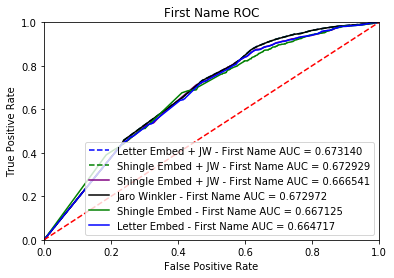

In [1110]:
# First name 
jw_first_fpr, jw_first_tpr, jw_first_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                           links['first-jaro-winkler'])
jw_first_roc_auc = sklearn.metrics.auc(jw_first_fpr, jw_first_tpr)

first_letter_fpr, first_letter_tpr, first_letter_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['letter_similarity_first'])
first_letter_roc_auc = sklearn.metrics.auc(first_letter_fpr, first_letter_tpr) 

first_shingle_fpr, first_shingle_tpr, first_shingle_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['shingle_similarity_first'])
first_shingle_roc_auc = sklearn.metrics.auc(first_shingle_fpr, first_shingle_tpr) 

# Max JW + Shingle 
links['combined_letter_jw_first'] = links[['first-jaro-winkler', 'letter_similarity_first']].max(axis=1)
combined_first_letter_fpr, combined_first_letter_tpr, combined_first_letter_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['combined_letter_jw_first'])
combined_first_letter_roc_auc = sklearn.metrics.auc(combined_first_letter_fpr, combined_first_letter_tpr) 

# Max JW + Letter 
links['combined_shingle_jw_first'] = links[['first-jaro-winkler', 'shingle_similarity_first']].max(axis=1)
combined_first_shingle_fpr, combined_first_shingle_tpr, combined_first_shingle_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['combined_shingle_jw_first'])
combined_first_shingle_roc_auc = sklearn.metrics.auc(combined_first_shingle_fpr, combined_first_shingle_tpr)

# Max Shingle + Letter 
links['combined_shingle_letter_first'] = links[['letter_similarity_first', 'shingle_similarity_first']].max(axis=1)
combined_shingle_letter_fpr, combined_shingle_letter_tpr, combined_shingle_letter_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                                       links['combined_shingle_letter_first'])
combined_shingle_letter_auc = sklearn.metrics.auc(combined_shingle_letter_fpr, combined_shingle_letter_tpr) 


plt.title('First Name ROC')

plt.plot(combined_first_letter_fpr, combined_first_letter_tpr, 'blue', linestyle='dashed',
         label = 'Letter Embed + JW - First Name AUC = {:2f}'.format(combined_first_letter_roc_auc))

plt.plot(combined_first_shingle_fpr, combined_first_shingle_tpr, 'green', linestyle='dashed',
         label = 'Shingle Embed + JW - First Name AUC = {:2f}'.format(combined_first_shingle_roc_auc))

plt.plot(combined_shingle_letter_fpr, combined_shingle_letter_tpr, 'purple',
         label = 'Shingle Embed + JW - First Name AUC = {:2f}'.format(combined_shingle_letter_auc))

plt.plot(jw_first_fpr, jw_first_tpr, 'black',
         label = 'Jaro Winkler - First Name AUC = {:2f}'.format(jw_first_roc_auc))

plt.plot(first_shingle_fpr, first_shingle_tpr, 'green',
         label = 'Shingle Embed - First Name AUC = {:2f}'.format(first_shingle_roc_auc))

plt.plot(first_letter_fpr, first_letter_tpr, 'blue', 
         label = 'Letter Embed - First Name AUC = {:2f}'.format(first_letter_roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

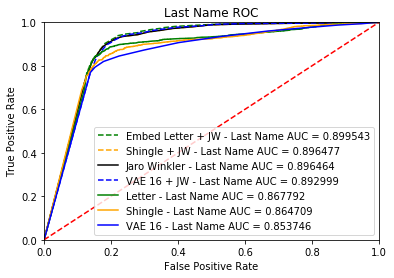

In [1178]:
# Last Name 
jw_last_fpr, jw_last_tpr, jw_last_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                        links['last-jaro-winkler'], 
                                                                       pos_label=1)
jw_last_auc = sklearn.metrics.auc(jw_last_fpr, jw_last_tpr)

vae_fpr, vae_tpr, vae_threshold = sklearn.metrics.roc_curve(links['match'], links['vae_enc_last'])
vae_roc_auc = sklearn.metrics.auc(vae_fpr, vae_tpr)

shingle_fpr, shingle_tpr, shingle_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                        links['shingle_similarity_last'])
shingle_roc_auc = sklearn.metrics.auc(shingle_fpr, shingle_tpr) 

letter_fpr, letter_tpr, letter_threshold = sklearn.metrics.roc_curve(links['match'], 
                                                                     links['letter_similarity_last'])
letter_roc_auc = sklearn.metrics.auc(letter_fpr, letter_tpr) 

# Take max of JW and VAE together 
links['combined'] = links[['last-jaro-winkler', 'vae_enc_last']].max(axis=1)
combined_fpr, combined_tpr, combined_threshold = sklearn.metrics.roc_curve(links['match'], links['combined'])
combined_roc_auc = sklearn.metrics.auc(combined_fpr, combined_tpr)

# Take max of Letter and Jaro Winkler
links['embed_combined'] = links[['letter_similarity_last','last-jaro-winkler']].max(axis=1)
embed_combined_fpr, embed_combined_tpr, embed_combined_threshold = sklearn.metrics.roc_curve(links['match'], links['embed_combined'])
embed_combined_roc_auc = sklearn.metrics.auc(embed_combined_fpr, embed_combined_tpr)

# Take max of Letter and Jaro Winkler
links['shingle_combined'] = links[['shingle_similarity_last','last-jaro-winkler']].max(axis=1)
shingle_combined_fpr, shingle_combined_tpr, shingle_combined_threshold = sklearn.metrics.roc_curve(links['match'],
                                                                                                   links['shingle_combined'])
shingle_combined_roc_auc = sklearn.metrics.auc(shingle_combined_fpr, shingle_combined_tpr)

plt.title('Last Name ROC')

plt.plot(embed_combined_fpr, embed_combined_tpr, 'g', linestyle='dashed',
         label = 'Embed Letter + JW - Last Name AUC = {:2f}'.format(embed_combined_roc_auc))

plt.plot(shingle_combined_fpr, shingle_combined_tpr, 'orange', linestyle='dashed',
         label = 'Shingle + JW - Last Name AUC = {:2f}'.format(shingle_combined_roc_auc))

plt.plot(jw_last_fpr, jw_last_tpr, 'black', 
         label = 'Jaro Winkler - Last Name AUC = {:2f}'.format(jw_last_auc))

plt.plot(combined_fpr, combined_tpr, 'b', linestyle='dashed',
         label = 'VAE 16 + JW - Last Name AUC = {:2f}'.format(combined_roc_auc))

plt.plot(letter_fpr, letter_tpr, 'g', 
         label = 'Letter - Last Name AUC = {:2f}'.format(letter_roc_auc))

plt.plot(shingle_fpr, shingle_tpr, 'orange', 
         label = 'Shingle - Last Name AUC = {:2f}'.format(shingle_roc_auc))

plt.plot(vae_fpr, vae_tpr, 'blue', 
         label = 'VAE 16 - Last Name AUC = {:2f}'.format(vae5_roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Estimated Links Based on a Single Column

In [1188]:
def optimal_threshold(col):
    fpr, tpr, threshold = sklearn.metrics.roc_curve(links['match'], links[col]) 
    distances = np.zeros(len(fpr))
    # Calculate distance to (0, 1)
    for i, j in enumerate(fpr):
        distances[i] += (j-0)**2 + (1 - tpr[i])**2
    return threshold[np.argmin(distances)]

In [1198]:
def linkage_results(col): 
    threshold = optimal_threshold(col)
    pred = (links[col] > threshold).astype(int) 
    print(col)
    print('Accuracy:', sklearn.metrics.accuracy_score(links['match'], pred))
    print('F1:', sklearn.metrics.f1_score(links['match'], pred))
    print('Precision:', sklearn.metrics.precision_score(links['match'], pred))
    print('Recall:', sklearn.metrics.recall_score(links['match'], pred))

In [1199]:
for col in ['first-jaro-winkler', 'last-jaro-winkler', 'vae_enc_last', 
            'letter_similarity_last', 'shingle_similarity_last', 
            'shingle_combined', 'embed_combined']:
    linkage_results(col)
    print('\n')

first-jaro-winkler
Accuracy: 0.6832360762764201
F1: 0.15584590064823833
Precision: 0.09114839115231996
Recall: 0.5370370370370371


last-jaro-winkler
Accuracy: 0.8379819265719723
F1: 0.36740317897741254
Precision: 0.23329791888006998
Recall: 0.8641203703703704


vae_enc_last
Accuracy: 0.8450777006163115
F1: 0.3581201044386423
Precision: 0.23122049898853675
Recall: 0.79375


letter_similarity_last
Accuracy: 0.8486066823790378
F1: 0.37716478274395937
Precision: 0.2430175063477215
Recall: 0.8418981481481481


shingle_similarity_last
Accuracy: 0.8363560742598591
F1: 0.3546719681908549
Precision: 0.22582278481012658
Recall: 0.825925925925926


shingle_combined
Accuracy: 0.8379819265719723
F1: 0.36740317897741254
Precision: 0.23329791888006998
Recall: 0.8641203703703704


embed_combined
Accuracy: 0.8230467716118625
F1: 0.35702509617145994
Precision: 0.22253939255537794
Recall: 0.9023148148148148




# Fellegi-Sunter

In [1121]:
import recordlinkage as rl

In [1148]:
matched_links = links[links['match']==1][['uid1915', 'hhid']]
matched_links.set_index(['uid1915', 'hhid'], inplace=True)

In [1208]:
features = links[['uid1915', 'hhid', 
                  'last-jaro-winkler','first-jaro-winkler', 'full-jaro-winkler']]
features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['first-jaro-winkler'] = (features['first-jaro-winkler'] > optimal_threshold('first-jaro-winkler')).astype(int)
features['full-jaro-winkler'] = (features['full-jaro-winkler'] > optimal_threshold('full-jaro-winkler')).astype(int)
features.set_index(['uid1915', 'hhid'], inplace=True)

ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 

11835
F1 0.36781182296502624
Accuracy 0.8712803902045549
Precision 0.25103506548373467
Recall 0.6877314814814814


In [1209]:
features = links[['uid1915', 'hhid', 
                  'last-jaro-winkler',
                  'shingle_similarity_last', 'shingle_similarity_first']]
features.set_index(['uid1915', 'hhid'], inplace=True)

features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['shingle_similarity_last'] = (features['shingle_similarity_last'] > optimal_threshold('shingle_similarity_last')).astype(int)
features['shingle_similarity_first'] = (features['shingle_similarity_first'] > optimal_threshold('shingle_similarity_first')).astype(int)


ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 

14744
F1 0.3792434020672648
Accuracy 0.8508879170185145
Precision 0.24519981002781735
Recall 0.836574074074074


In [1210]:
features = links[['uid1915', 'hhid', 
                  'last-jaro-winkler', 
                  'letter_similarity_last', 'letter_similarity_first']]
features.set_index(['uid1915', 'hhid'], inplace=True)

features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['letter_similarity_last'] = (features['letter_similarity_last'] > optimal_threshold('letter_similarity_last')).astype(int)
features['letter_similarity_first'] = (features['letter_similarity_first'] > optimal_threshold('letter_similarity_first')).astype(int)

ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 

14713
F1 0.3822787471095228
Accuracy 0.8518583870032643
Precision 0.2472803916236062
Recall 0.8418981481481481


In [1211]:
features = links[['uid1915', 'hhid', 
                  'last-jaro-winkler', 'first-jaro-winkler',
                  'shingle_similarity_last', 'shingle_similarity_first', 
                  'letter_similarity_last', 'letter_similarity_first']]
features.set_index(['uid1915', 'hhid'], inplace=True)

features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['first-jaro-winkler'] = (features['first-jaro-winkler'] > optimal_threshold('first-jaro-winkler')).astype(int)
features['letter_similarity_last'] = (features['letter_similarity_last'] > optimal_threshold('letter_similarity_last')).astype(int)
features['letter_similarity_first'] = (features['letter_similarity_first'] > optimal_threshold('letter_similarity_first')).astype(int)
features['shingle_similarity_last'] = (features['shingle_similarity_last'] > optimal_threshold('shingle_similarity_last')).astype(int)
features['shingle_similarity_first'] = (features['shingle_similarity_first'] > optimal_threshold('shingle_similarity_first')).astype(int)

ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 

14855
F1 0.37214397496087637
Accuracy 0.848304198227947
Precision 0.2402020202020202
Recall 0.8256944444444444


In [1213]:
features = links[['uid1915', 'hhid',
                  'last-jaro-winkler', 'first-jaro-winkler',
                  'shingle_similarity_last', 'shingle_similarity_first', 
                  'letter_similarity_last', 'letter_similarity_first',
                  'vae_enc_last']]
features.set_index(['uid1915', 'hhid'], inplace=True)

features['last-jaro-winkler'] = (features['last-jaro-winkler'] > optimal_threshold('last-jaro-winkler')).astype(int)
features['first-jaro-winkler'] = (features['first-jaro-winkler'] > optimal_threshold('first-jaro-winkler')).astype(int)
features['letter_similarity_last'] = (features['letter_similarity_last'] > optimal_threshold('letter_similarity_last')).astype(int)
features['letter_similarity_first'] = (features['letter_similarity_first'] > optimal_threshold('letter_similarity_first')).astype(int)
features['shingle_similarity_last'] = (features['shingle_similarity_last'] > optimal_threshold('shingle_similarity_last')).astype(int)
features['shingle_similarity_first'] = (features['shingle_similarity_first'] > optimal_threshold('shingle_similarity_first')).astype(int)
features['vae_enc_last'] = (features['vae_enc_last'] > optimal_threshold('vae_enc_last')).astype(int)

ecm = rl.ECMClassifier()
result_ecm = ecm.learn(features)
print(len(result_ecm))

conf_ecm = rl.confusion_matrix(matched_links, result_ecm, len(features))
print('F1', rl.fscore(conf_ecm)) 
print('Accuracy', rl.accuracy(conf_ecm)) 
print('Precision', rl.precision(conf_ecm)) 
print('Recall', rl.recall(conf_ecm)) 

14262
F1 0.38047047424234276
Accuracy 0.85494624604565
Precision 0.24787823525285824
Recall 0.8180555555555555
